In [37]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime

Data = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

In [38]:
Data.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


# Calculating missing values in rows

From the dataset you can see that something does not make sense. Theoretically, Aboard = Fatalities + Ground, but it does not look like this. Maybe because the people with missig bodies doesn't count to Fatalities, or some other reasons. We just skipped Ground row for any further analysis. Meanwhile, we found some missing values in (Date, Operator, Aboard, Fatalities, ...). Therefore, let's look at how data looks like and check how many missing values are here.

In [39]:
Data.isnull().sum() # calculating missing values in rows

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
dtype: int64

# Data cleaning

We want to create a new row with 'Date + Time' format and replaced all the missing values of Time with 0:00. Then removed some wrong symbols and fixed broken values.

In [40]:
Data['Time'] = Data['Time'].replace(np.nan, '00:00') 
Data['Time'] = Data['Time'].str.replace('c: ', '')
Data['Time'] = Data['Time'].str.replace('c:', '')
Data['Time'] = Data['Time'].str.replace('c', '')
Data['Time'] = Data['Time'].str.replace('12\'20', '12:20')
Data['Time'] = Data['Time'].str.replace('18.40', '18:40')
Data['Time'] = Data['Time'].str.replace('0943', '09:43')
Data['Time'] = Data['Time'].str.replace('22\'08', '22:08')
Data['Time'] = Data['Time'].str.replace('114:20', '00:00') #is it 11:20 or 14:20 or just wrong? 

Data['Time'] = Data['Date'] + ' ' + Data['Time'] 
def todate(x):
    return datetime.strptime(x, '%m/%d/%Y %H:%M')
Data['Time'] = Data['Time'].apply(todate) #convert to date type


print('Date ranges from ' + str(Data.Time.min()) + ' to ' + str(Data.Time.max()))

Data.Operator = Data.Operator.str.upper() #just to avoid duplicates like 'British Airlines' and 'BRITISH Airlines'

Date ranges from 1908-09-17 17:18:00 to 2009-06-08 00:00:00


## Count of accidents by Year

We count the amount of air accidents by year, to show the development of aviation safety.

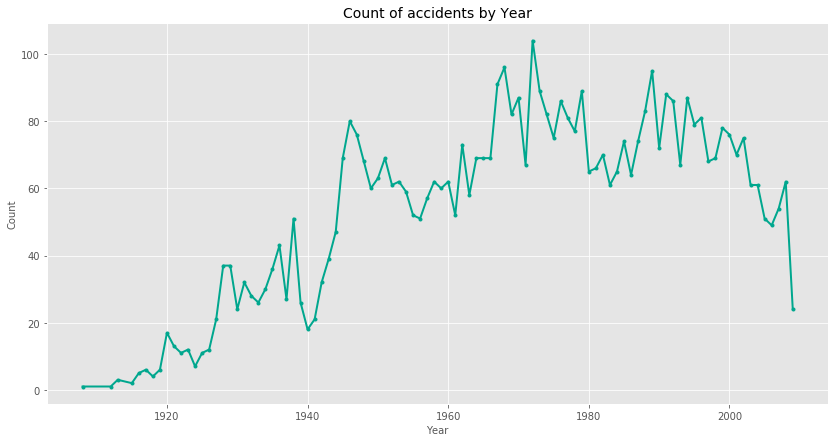

In [41]:
Temp = Data.groupby(Data.Time.dt.year)[['Date']].count() 
Temp = Temp.rename(columns={"Date": "Count"})

plt.figure(figsize=(14,7))
plt.style.use('ggplot')
plt.plot(Temp.index, 'Count', data=Temp, color='#00a78e',marker = ".", linewidth=2)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Year', loc='Center', fontsize=14)
plt.show()

## Compare the accidents in Military vs in Passenger

We compare the amount of air accidents happened in military field and in passenger field, to show the development of aviation functions.

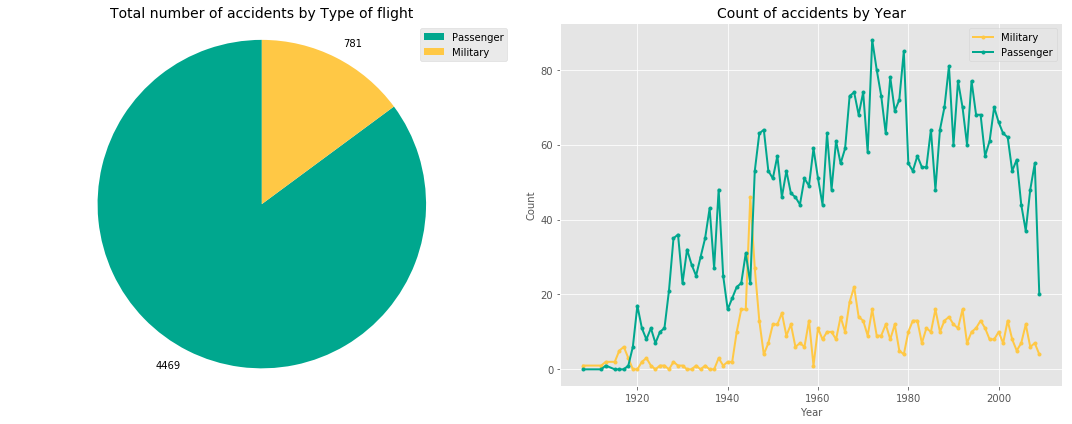

In [42]:
Temp = Data.copy()
Temp['isMilitary'] = Temp.Operator.str.contains('MILITARY')
Temp = Temp.groupby('isMilitary')[['isMilitary']].count()
Temp.index = ['Passenger', 'Military']

Temp2 = Data.copy()
Temp2['Military'] = Temp2.Operator.str.contains('MILITARY')
Temp2['Passenger'] = Temp2.Military == False
Temp2 = Temp2.loc[:, ['Time', 'Military', 'Passenger']]
Temp2 = Temp2.groupby(Temp2.Time.dt.year)[['Military', 'Passenger']].aggregate(np.count_nonzero)

colors = [ '#00a78e', '#ffc845']
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
patches, texts = plt.pie(Temp.isMilitary, colors=colors, labels=Temp.isMilitary, startangle=90)
plt.legend(patches, Temp.index, loc="best", fontsize=10)
plt.axis('equal')
plt.title('Total number of accidents by Type of flight', loc='Center', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(Temp2.index, 'Military', data=Temp2, color='#ffc845', marker = ".", linewidth=2)
plt.plot(Temp2.index, 'Passenger', data=Temp2, color='#00a78e',marker = ".", linewidth=2)
plt.legend(fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Year', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()

## The possibility of survived 

We compare the number of aboard and fatalities every year, to see the chances of survival in air accidents.

Text(0.5,1,'Total number of people involved by Year')

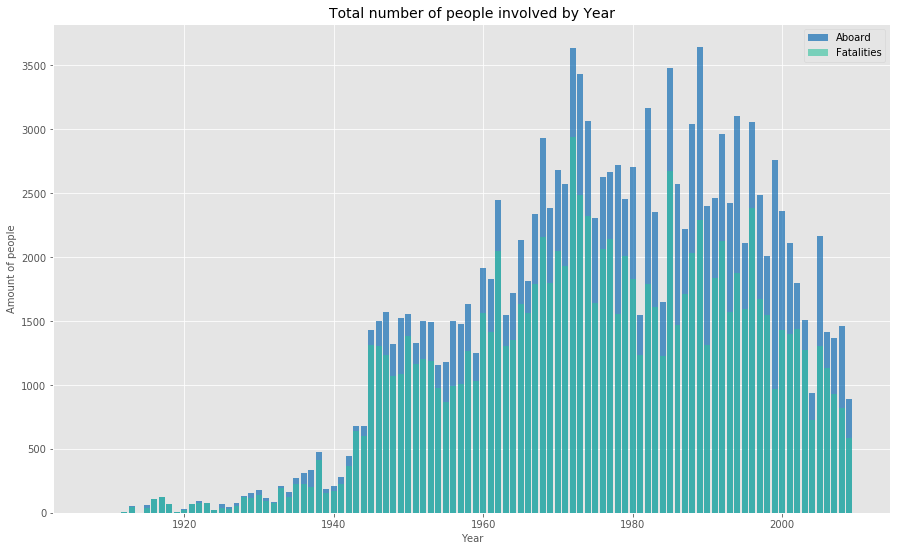

In [43]:
Fatalities = Data.groupby(Data.Time.dt.year).sum()
Fatalities['Proportion'] = Fatalities['Fatalities'] / Fatalities['Aboard']

plt.figure(figsize=(15,9))
plt.bar(Fatalities['Aboard'].index,Fatalities['Aboard'],label = 'Aboard', color = '#146eb4', alpha = 0.7)
plt.bar(Fatalities['Fatalities'].index,Fatalities['Fatalities'],label = 'Fatalities',color = '#30c39e',alpha = 0.6)
plt.legend(fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Amount of people', fontsize=10)
plt.title('Total number of people involved by Year', loc='Center', fontsize=14)

In [44]:
Totals = pd.read_csv('Air transport departures worldwide.csv')

In [45]:
Totals.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1959,1960,1961,1962,1963,1964,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21677.0,25021.000000,17775.000000,21696.0,25920.0,23532.128,22770.566
2,Angola,AGO,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,5277.0,3361.0,3236.0,17060.0,12282.000000,13072.000000,14496.0,13716.0,13116.000,13042.376
3,Albania,ALB,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,4930.0,5058.0,5140.0,9412.0,10373.210942,10309.179138,11196.0,1992.0,NaN,306.000
4,Andorra,AND,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

In [46]:
Totals = Totals.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis = 1)
Totals = Totals.replace(np.nan, 0)
Totals = pd.DataFrame(Totals.sum())
Totals = Totals.drop(Totals.index[0:10])
Totals = Totals['1970':'2008']
Totals.columns = ['Sum']
Totals.index.name = 'Year'

In [47]:
Fatalities = Fatalities.reset_index()
Fatalities.Time = Fatalities.Time.apply(str)
Fatalities.index = Fatalities['Time']
del Fatalities['Time']
Fatalities = Fatalities['1970':'2008']
Fatalities = Fatalities[['Fatalities']]
Totals = pd.concat([Totals, Fatalities], axis=1) #joining two data frames into one
Totals['Ratio'] = Totals['Fatalities'] / Totals['Sum'] * 100 #calculating ratio

## Fatalities / Total amount of passegers Ratio by Year

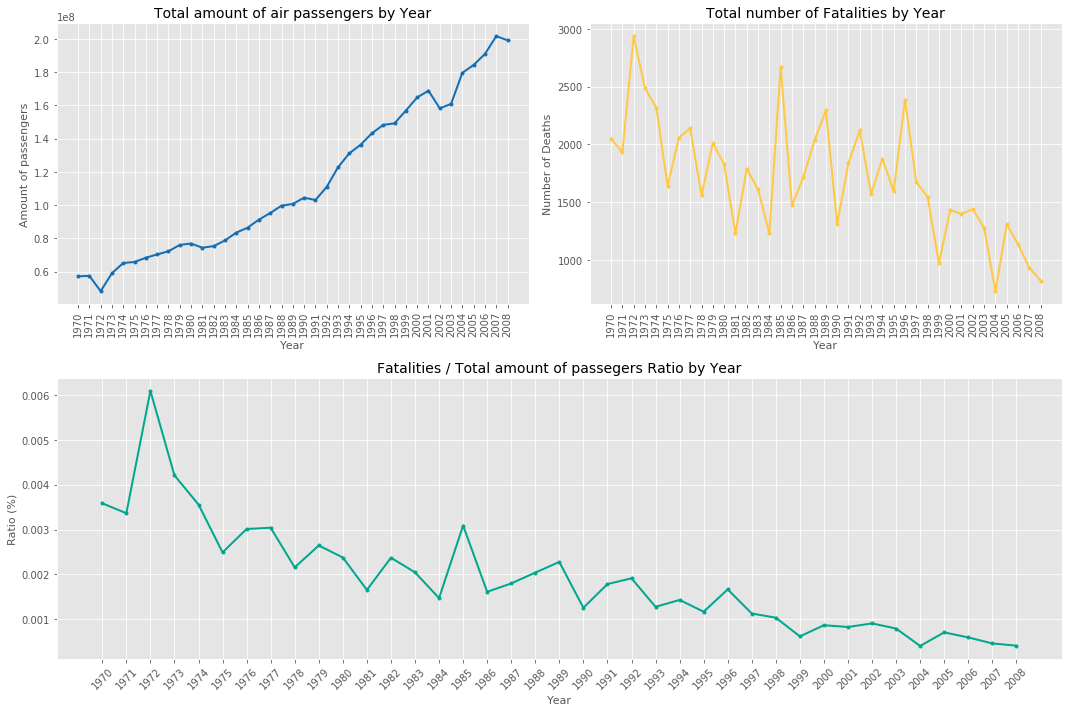

In [48]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
plt.figure(figsize=(15,10))

ax = plt.subplot(gs[0, 0]) 
plt.plot(Totals.index, 'Sum', data=Totals, marker = ".", color = '#146eb4', linewidth=2)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Amount of passengers', fontsize=11)
plt.title('Total amount of air passengers by Year', loc='Center', fontsize=14)
plt.xticks(rotation=90)

ax = plt.subplot(gs[0, 1]) 
plt.plot(Fatalities.index, 'Fatalities', data=Fatalities, color='#ffc845', marker = ".", linewidth=2)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Number of Deaths', fontsize=11)
plt.title('Total number of Fatalities by Year', loc='Center', fontsize=14)
plt.xticks(rotation=90)

ax = plt.subplot(gs[1, :]) 
plt.plot(Totals.index, 'Ratio', data=Totals, color='#00a78e', marker = ".", linewidth=2)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Ratio (%)', fontsize=11)
plt.title('Fatalities / Total amount of passegers Ratio by Year', loc='Center', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Operators Analysis

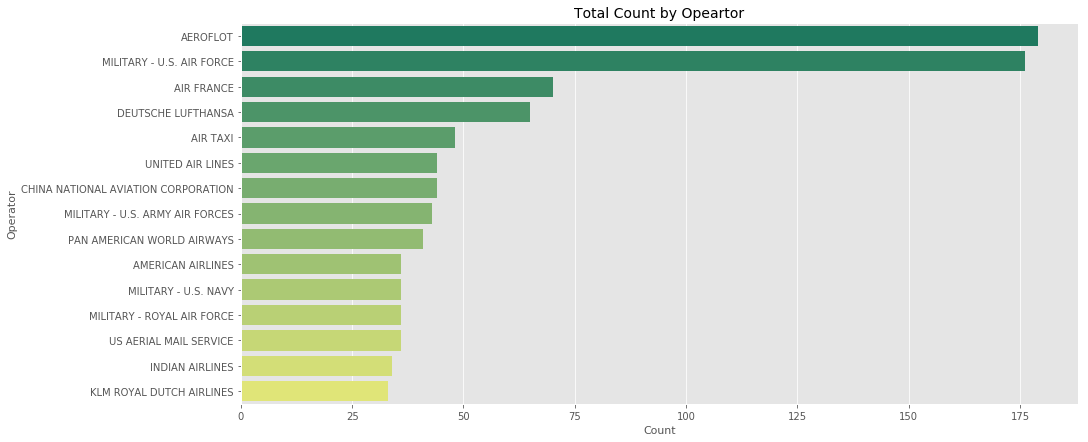

In [49]:
Data.Operator = Data.Operator.str.upper()
Data.Operator = Data.Operator.replace('A B AEROTRANSPORT', 'AB AEROTRANSPORT')

Prop_by_Op = Data.groupby('Operator')[['Fatalities']].sum()
Prop_by_Op = Prop_by_Op.rename(columns={"Operator": "Fatalities"})
Prop_by_Op = Prop_by_Op.sort_values(by='Fatalities', ascending=False)
Prop_by_OpTOP = Prop_by_Op.head(15)


Total_by_Op = Data.groupby('Operator')[['Operator']].count()
Total_by_Op = Total_by_Op.rename(columns={"Operator": "Count"})
Total_by_Op = Total_by_Op.sort_values(by='Count', ascending=False).head(15)

plt.figure(figsize=(15,7))
sns.barplot(y=Total_by_Op.index, x="Count", data=Total_by_Op, palette="summer", orient='h',label = 'Count')
#sns.barplot(y=Prop_by_OpTOP.index, x="Fatalities", data=Prop_by_OpTOP, palette="Blues_d", orient='h',label = 'Fatalities')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Operator', fontsize=11)
plt.title('Total Count by Opeartor', loc='Center', fontsize=14)
plt.show()

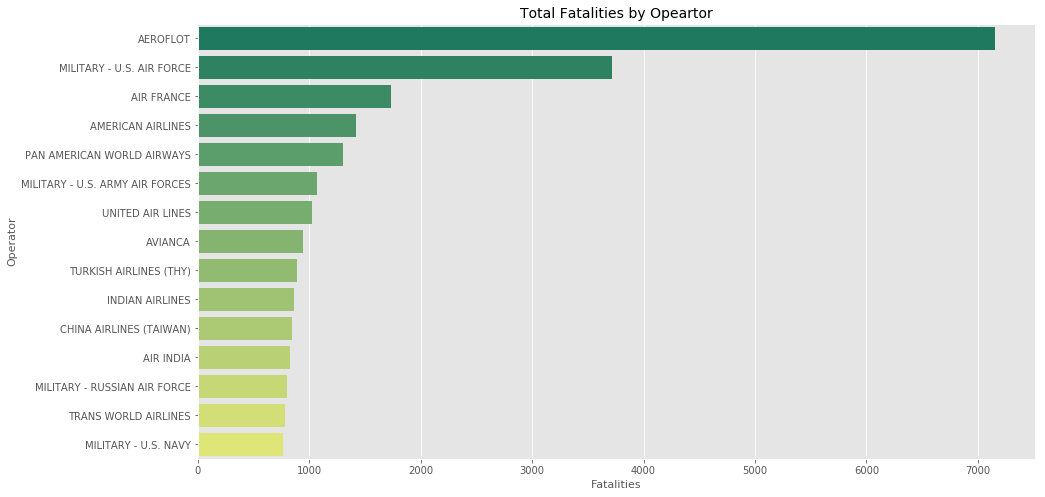

In [50]:
Prop_by_Op = Data.groupby('Operator')[['Fatalities']].sum()
Prop_by_Op = Prop_by_Op.rename(columns={"Operator": "Fatalities"})
Prop_by_Op = Prop_by_Op.sort_values(by='Fatalities', ascending=False)
Prop_by_OpTOP = Prop_by_Op.head(15)

plt.figure(figsize=(15,8))
sns.barplot(y=Prop_by_OpTOP.index, x="Fatalities", data=Prop_by_OpTOP, palette="summer", orient='h')
plt.xlabel('Fatalities', fontsize=11)
plt.ylabel('Operator', fontsize=11)
plt.title('Total Fatalities by Opeartor', loc='Center', fontsize=14)
plt.show()

## the Type of Airplane Analysis

In [51]:
Data = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

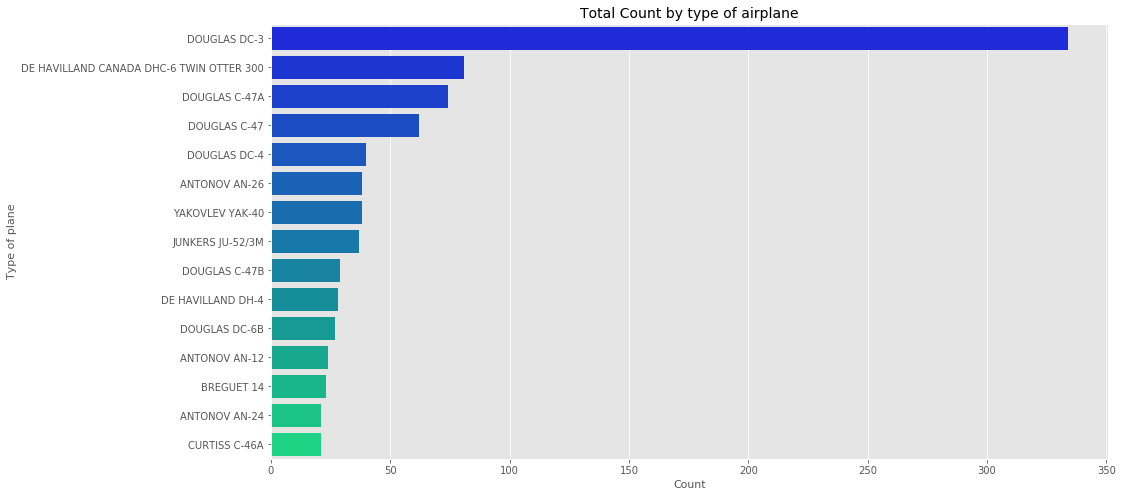

In [52]:
Data.Type = Data.Type.str.upper()
Total_by_Ty = Data.groupby('Type')[['Type']].count()
Total_by_Ty = Total_by_Ty.rename(columns={"Type": "Count"})
Total_by_Ty = Total_by_Ty.sort_values(by='Count', ascending=False).head(15)

plt.figure(figsize=(15,8))
sns.barplot(y=Total_by_Ty.index, x="Count", data=Total_by_Ty, palette="winter", orient='h')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Type of plane', fontsize=11)
plt.title('Total Count by type of airplane', loc='Center', fontsize=14)
plt.show()

## World Clouds

Location of accident

In [53]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

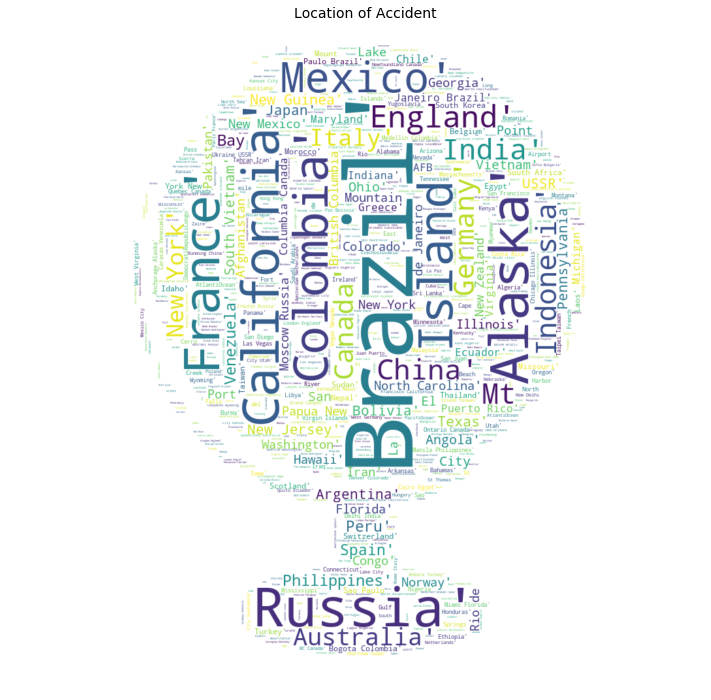

In [54]:
text = str(Data.Location.tolist())
globe_mask = np.array(Image.open('globe.jpg'))

stopwords = set(STOPWORDS)
stopwords.add('nan')
stopwords.add('Near')

wc = WordCloud(background_color="white", max_words=2000, mask=globe_mask,
               stopwords=stopwords)
wc.generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Location of Accident', loc='Center', fontsize=14)
plt.show()

## The relationship between Opeartor and Type

In [55]:
Data2 = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

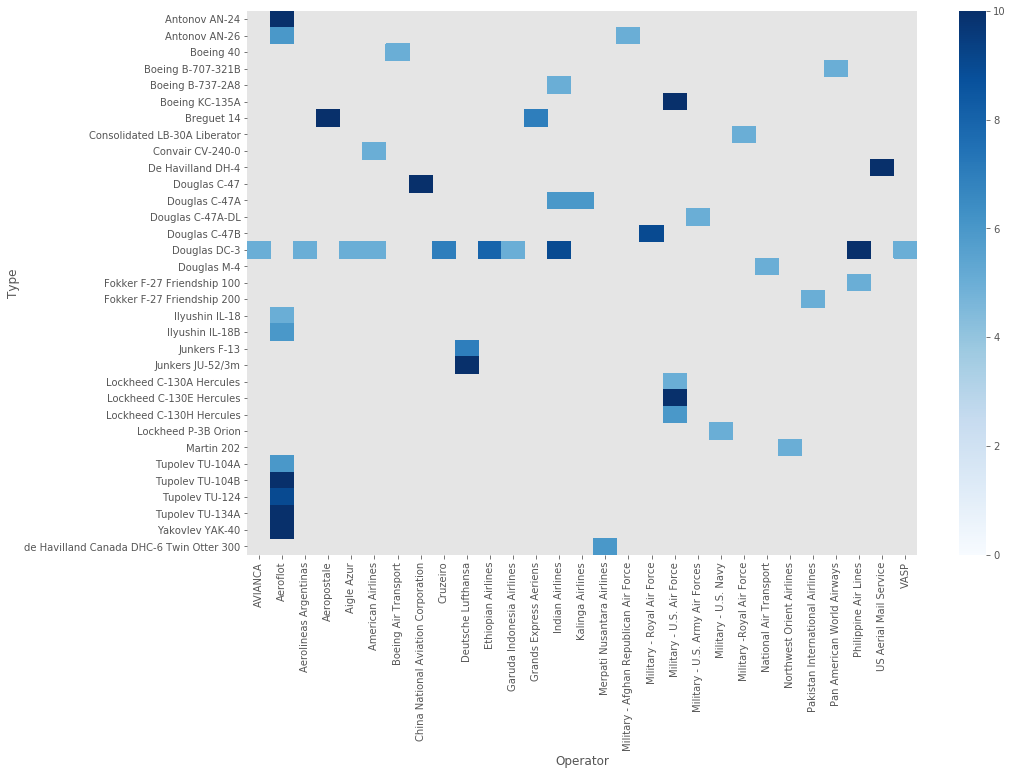

In [56]:
import seaborn
df2 = pd.DataFrame(Data2[['Type','Operator']])
df2 = pd.DataFrame(data={'Type':df2.groupby(['Type','Operator']).size().index.get_level_values('Type'),'Operator':df2.groupby(['Type','Operator']).size().index.get_level_values('Operator'),'Count':df2.groupby(['Type','Operator']).size()})
df2 = df2.reset_index(drop=True)
df2 =df2.sort_values('Count', ascending=False)
df2 = df2[df2['Count']>4].pivot(index='Type', columns='Operator', values='Count')
df2 = df2.replace(to_replace='NaN', value=0)
plt.figure(figsize=(15,10))
seaborn.heatmap(df2, cmap='Blues',vmin=0, vmax=10)
plt.yticks(np.arange(0.5, len(df2.index), 1), df2.index)
plt.xticks(np.arange(0.5, len(df2.columns), 1), df2.columns, rotation='vertical')
plt.show()

## Preparation for world map

In [57]:
Data2['path'] = Data2['Route'].fillna(0)
path = []
for i in range(0,len(Data2['path'])):
    if Data2['path'][i]!= 0:
        path.append(Data2['path'][i].split(' - '))
path2 = []
for i in range(0,len(path)):
    if len(path[i]) > 1:
        path2.append(path[i])
path4 = []
for i in range(0,len(path2)):
    path3 = []
    for j in range(0,len(path2[i])):
        path3.append(path2[i][j].split(',')[0])
    path4.append(path3)

In [58]:
Data3 = pd.read_csv('simplemaps-worldcities-basic.csv')

In [59]:
path6 = []
for i in range(0,len(path4)):
    path5 = []
    for j in range(0,len(path4[i])):
        if path4[i][j] in Data3['city'].values:
            path5.append(path4[i][j])
            path5.append(Data3[Data3['city'].values == path4[i][j]]['lat'].values[0])
            path5.append(Data3[Data3['city'].values == path4[i][j]]['lng'].values[0])
    path6.append(path5)
path7 = []
for i in range(0,len(path6)):
    if len(path6[i])>4:
        path7.append(path6[i])
path9 = []
for i in range(0,len(path7)):
    for j in range(0,int(len(path7[i])/3)):
        path8 = []
        path8.append(path7[i][3*j])
        path8.append(path7[i][3*j+1])
        path8.append(path7[i][3*j+2])
    path9.append(path8)

In [60]:
import csv
with open('station.csv','w',newline='') as f:
    writer = csv.writer(f)
    header = ['station','lat','lng']
    writer.writerow(header)
    writer.writerows(path9)

## Flight paths in world map

In [61]:
df_flight_paths = pd.read_csv('path.csv')
df_airports = pd.read_csv('station.csv')

### Plot airports

In [62]:
airports1 = [ dict(
        type = 'scattergeo',
        lon = df_airports['lng'],
        lat = df_airports['lat'],
        mode = 'markers',
        marker = dict( 
            size=3,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ))]
airports2 = [ dict(
        type = 'scattergeo',
        lon = df_airports['lng'],
        lat = df_airports['lat'],
        mode = 'markers',
        marker = dict( 
            size=1,
            color='rgb(255, 0, 0)',
            opacity=1
        ))]

### Plot flight paths

In [63]:
flight_paths = []
for i in range( len( df_flight_paths ) ):
    flight_paths.append(
        dict(
            type = 'scattergeo',
            lon = [ df_flight_paths['start_lon'][i], df_flight_paths['end_lon1'][i] ],
            lat = [ df_flight_paths['start_lat'][i], df_flight_paths['end_lat1'][i] ],
            mode = 'lines',
            line = dict(
                width = 0.5,
                alpha = 0.2,
                color = 'blue',
            )
        )
    )

### Setting layout

In [64]:
layout = dict(
        title = 'flight path',
        showlegend = False,         
        geo = dict(
            projection = dict( type="world" ),
            resolution = 50,
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',

            lataxis = dict(
                #range = [ 20, 60],
                showgrid = False,
                tickmode = "linear",
                dtick = 50
            ),
            lonaxis = dict(
                #range = [-100, 20],
                showgrid = False,
                tickmode = "linear",
                dtick = 60
            ),
        ),
    )

### Output

In [69]:
plotly.offline.init_notebook_mode(connected=True)
fig = dict( data=airports1+airports2+flight_paths, layout=layout )
plotly.offline.iplot(fig, validate=False, filename='Flight Path')